In [1]:
from src.data.polynomial_dgp import PolynomialDGP
from src.algorithms.tlearner import TLearner
import matplotlib.pyplot as plt

In [2]:
dgp = PolynomialDGP(
    polynomial_degree=2,
    confounding_strength=1.0,
    n_effect_modifiers=1,
    n_confounders=1,
    n_instruments=0,
    binary_outcome=False,
    seed=42,
)

data = dgp.sample(500)
feature_names = dgp.get_feature_names()
data.describe()

,X_c1,X_m1,T,Y,_Y0,_Y1,_cate
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.003539,0.051543,0.506000,2.758974,1.858666,3.517335,1.658669
std,0.983472,0.980422,0.500465,2.989138,2.440919,3.356086,1.429306
min,-3.241267,-2.696887,0.000000,-3.206860,-3.206860,-2.926207,-2.791046
25%,-0.714589,-0.574156,0.000000,1.046550,0.427996,1.788325,1.043371
50%,0.007738,0.057472,1.000000,2.158158,1.457729,2.901111,1.395605
75%,0.628666,0.685470,1.000000,3.589462,2.612863,4.253482,2.082475
max,3.852731,2.632382,1.000000,20.737684,20.737684,28.161438,10.920383


## Inspect distribution of covariates in T=1 and T=0
- If the histograms look different for some T=1 and T=0, that could indicate that there can be confounding between T=1 and T=0 since there is a systematic difference in treatment assignment w.r.t. to the covariate.
- We also want to verify that the histograms for T=1 and T=0 are overlapping, this is important for determining whether the positivy assumption holds.

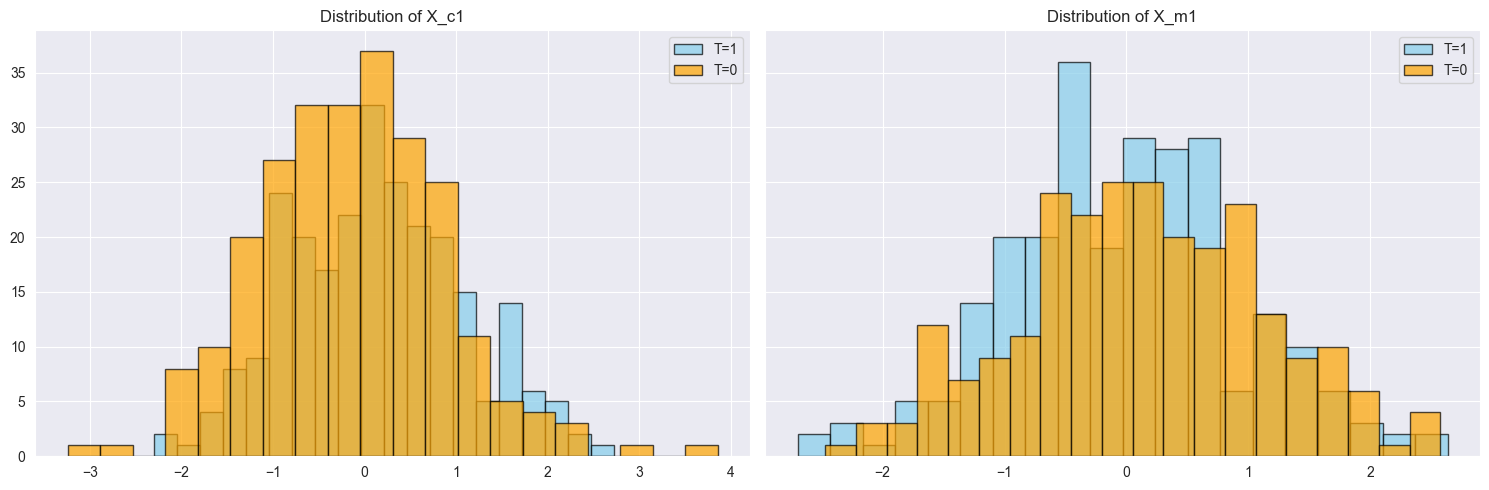

In [3]:


# Create a grid of histograms, one per covariate
fig, axes = plt.subplots(1, len(feature_names), figsize=(15, 5), sharey=True)

for ax, feat in zip(axes, feature_names):
    data[data['T'] == 1][feat].hist(ax=ax, bins=20, alpha=0.7, color='skyblue', edgecolor='black', label='T=1')
    data[data['T'] == 0][feat].hist(ax=ax, bins=20, alpha=0.7, color='orange', edgecolor='black', label='T=0')
    ax.set_title(f'Distribution of {feat}')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

# Inspect outcome as function of each feature
- Top row: observed outcomes
- Bottom row: plotting the CATE, this is unobserved but what we want to estimate.

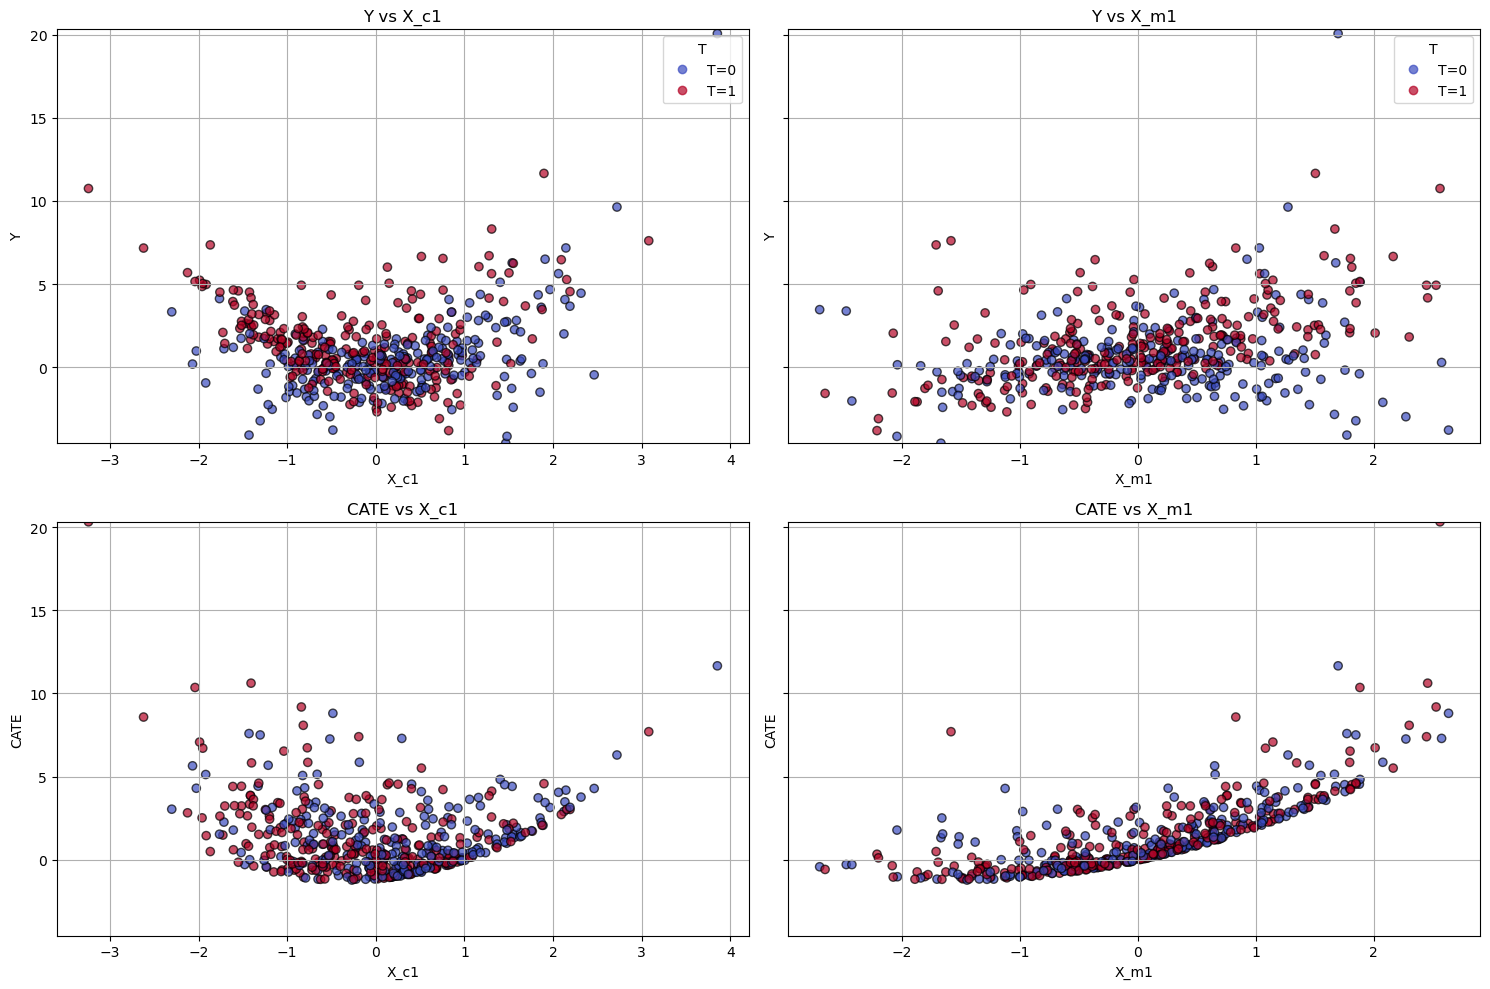

In [20]:
# Create a grid of scatter plots, one per covariate
fig, axes = plt.subplots(2, len(feature_names), figsize=(15, 10), sharey='row')

for i, feat in enumerate(feature_names):
    # Plot Y vs feat
    scatter = axes[0, i].scatter(
        data[feat], data['Y'], c=data['T'], cmap='coolwarm', alpha=0.7, edgecolor='black'
    )
    handles, labels = scatter.legend_elements(prop="colors", alpha=0.7)
    axes[0, i].legend(handles, ['T=0', 'T=1'], title="T")
    axes[0, i].set_title(f'Y vs {feat}')
    axes[0, i].set_xlabel(feat)
    axes[0, i].set_ylabel('Y')
    axes[0, i].grid(True)

    # Plot CATE vs feat
    scatter_cate = axes[1, i].scatter(
        data[feat], data['_cate'], c=data['T'], cmap='coolwarm', alpha=0.7, edgecolor='black'
    )
    axes[1, i].set_title(f'CATE vs {feat}')
    axes[1, i].set_xlabel(feat)
    axes[1, i].set_ylabel('CATE')
    axes[1, i].grid(True)

# Set the same ylim for all rows
y_min = min(data['Y'].min(), data['_cate'].min())
y_max = max(data['Y'].max(), data['_cate'].max())
for ax_row in axes:
    for ax in ax_row:
        ax.set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

# Illustration of simple experiment
- We noted that there appears to be nonlinear relationships between the observed outcome and features, we can thus hypothesize that a nonlinear CATE learner will perform better than a linear one.
- We come up with an experiment where we test a nonlinear and linear variant of the T-learner (a very basic CATE learner), which one should perform better if we compute their mean-squared error on a test set?
- The experiment must repeated multiple times so that we can draw solid conclusions that exlclude one model performing better due to chance.

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm.notebook import tqdm

# Repeat experiment 50 times
n_repeats = 50
mse_rf_list = []
mse_linear_list = []

for _ in tqdm(range(n_repeats)):
    # Generate train and test set
    train_data = dgp.sample(500)
    test_data = dgp.sample(500)

    t_learner_rf = TLearner(base_model=RandomForestRegressor())
    t_learner_linear = TLearner(base_model=LinearRegression())

    X_train = train_data[feature_names].values
    T_train = train_data['T']
    Y_train = train_data['Y']
    t_learner_rf.fit(X_train, T_train, Y_train)
    t_learner_linear.fit(X_train, T_train, Y_train)

    # Evaluate Tlearner on test_data where true labels are found in _cate
    X_test = test_data[feature_names].values
    cate_pred_rf = t_learner_rf.predict(X_test)
    cate_pred_linear = t_learner_linear.predict(X_test)

    # Compute MSE of models
    mse_rf = mean_squared_error(test_data['_cate'], cate_pred_rf)
    mse_linear = mean_squared_error(test_data['_cate'], cate_pred_linear)

    mse_rf_list.append(mse_rf)
    mse_linear_list.append(mse_linear)

# Compute average MSE and standard error
avg_mse_rf = np.mean(mse_rf_list)
std_err_rf = np.std(mse_rf_list) / np.sqrt(n_repeats)

avg_mse_linear = np.mean(mse_linear_list)
std_err_linear = np.std(mse_linear_list) / np.sqrt(n_repeats)

print(f"Random Forest T-Learner: Average MSE = {avg_mse_rf:.4f}, Standard Error = {std_err_rf:.4f}")
print(f"Linear Regression T-Learner: Average MSE = {avg_mse_linear:.4f}, Standard Error = {std_err_linear:.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]

Random Forest T-Learner: Average MSE = 1.3326, Standard Error = 0.0464
Linear Regression T-Learner: Average MSE = 3.4306, Standard Error = 0.1313
